In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error

# Load dataset
df = pd.read_csv("bed_data.csv")  # Ensure this dataset exists

# Ensure Date column is properly formatted
if 'Date' not in df.columns:
    df['Date'] = pd.date_range(start="2024-01-01", periods=len(df), freq='D')
else:
    df['Date'] = pd.to_datetime(df['Date'])  # Convert if already in CSV

df.set_index('Date', inplace=True)

# Selecting the target variable
y = df['Total_Beds_Occupied_Today']

# Function to perform ADF test
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Test p-value: {result[1]:.5f}')
    if result[1] > 0.05:
        print("Series is NOT stationary. Differencing needed.")
        return False
    else:
        print("Series is stationary. No differencing needed.")
        return True

# Step 1: Check Stationarity
if not adf_test(y):
    y = y.diff().dropna()  # First-order differencing
    adf_test(y)  # Recheck stationarity


ADF Test p-value: 0.97607
Series is NOT stationary. Differencing needed.
ADF Test p-value: 0.00000
Series is stationary. No differencing needed.


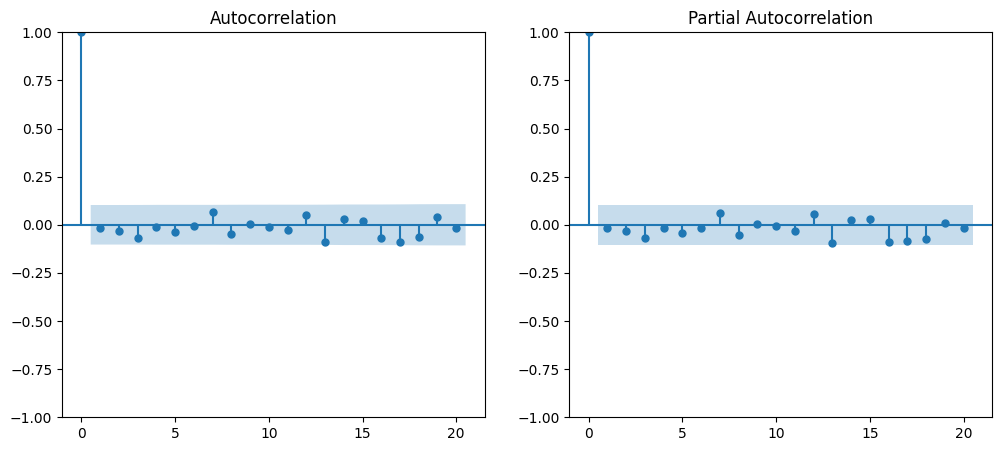

In [30]:
# Step 2: Plot ACF & PACF to determine p and q
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(y, ax=ax[0], lags=20)
plot_pacf(y, ax=ax[1], lags=20)
plt.show()


In [31]:
df.head()

,Total_Admissions_Today,Total_Discharges_Today,Avg_LOS,Avg_Age_Admissions_Today,Total_Beds_Occupied_Today,Total_Beds_Required_Tomorrow
Date,,,,,,
2024-01-01,48,33,4.28,32,115,122
2024-01-02,30,23,3.70,35,122,124
2024-01-03,45,28,7.56,77,139,135
2024-01-04,33,34,4.49,45,138,133
2024-01-05,21,26,3.05,49,133,128


MAE: 214.22
RMSE: 244.48
R²: -3.34

MAE: 159.07
RMSE: 193.82
R²: -1.84

MAE: 245.25
RMSE: 271.51
R²: -6.41

MAE: 202.89
RMSE: 276.61
R²: -3.70

MAE: 254.40
RMSE: 344.72
R²: -4.34

Top 10 Features:
                      feature  importance
22                  month_cos    0.550414
4   Total_Beds_Occupied_Today    0.205062
5                     quarter    0.171736
21                  month_sin    0.049438
17         admissions_per_bed    0.022370
0      Total_Admissions_Today    0.000180
2                     Avg_LOS    0.000146
15          avg_admissions_7d    0.000129
18        los_admission_ratio    0.000095
16         discharge_trend_3d    0.000089


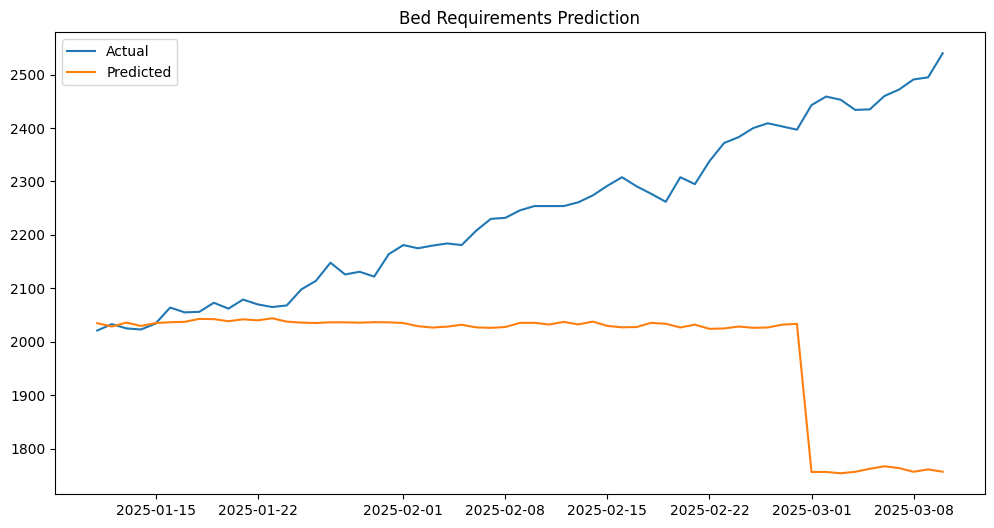

In [34]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Load and preprocess data
df = pd.read_csv('bed_data.csv')
df['date'] = pd.date_range(end='2025-03-11', periods=len(df), freq='D')  # Create datetime index
df.set_index('date', inplace=True)

# Feature Engineering
df['day_of_week'] = df.index.dayofweek  # 0=Monday
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

# Lag Features
for i in [1, 2, 3, 7]:  # Previous days and weekly pattern
    df[f'admissions_lag_{i}'] = df['Total_Admissions_Today'].shift(i)
    df[f'discharges_lag_{i}'] = df['Total_Discharges_Today'].shift(i)

# Rolling Features
df['avg_admissions_7d'] = df['Total_Admissions_Today'].rolling(7).mean()
df['discharge_trend_3d'] = df['Total_Discharges_Today'].rolling(3).mean()

# Interaction Features
df['admissions_per_bed'] = df['Total_Admissions_Today'] / df['Total_Beds_Occupied_Today']
df['los_admission_ratio'] = df['Avg_LOS'] / df['Total_Admissions_Today']

# Encode cyclical features
def encode_cyclical(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df.drop(col, axis=1)

df = encode_cyclical(df, 'day_of_week', 6)
df = encode_cyclical(df, 'month', 12)

# Prepare data
target = 'Total_Beds_Required_Tomorrow'
features = [col for col in df.columns if col != target]
X = df[features].iloc[7:-1]  # Account for lag features
y = df[target].iloc[7:-1]

# Time-series split
tscv = TimeSeriesSplit(n_splits=5)
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train and validate
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)
    
    preds = model.predict(X_test)
    print(f"MAE: {mean_absolute_error(y_test, preds):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.2f}")
    print(f"R²: {r2_score(y_test, preds):.2f}\n")

# Feature Importance
importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Features:")
print(importance.head(10))

# Plot predictions vs actual
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, preds, label='Predicted')
plt.title('Bed Requirements Prediction')
plt.legend()
plt.show()


Epoch 1/100


c:\Users\HARSHDIP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 4595759.5000 - val_loss: 15143558.0000
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4308242.5000 - val_loss: 10507918.0000
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2033537.2500 - val_loss: 202875.6250
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 236531.5625 - val_loss: 280466.7188
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 140691.7812 - val_loss: 153487.9062
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 92382.2109 - val_loss: 99212.4297
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 59266.8398 - val_loss: 48282.6719
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 36477.7969 - val_loss: 28685.3008
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 26003.4258 - val_loss: 25665.9473
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18255.6035 - val_loss: 30443.6348
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 158

c:\Users\HARSHDIP\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


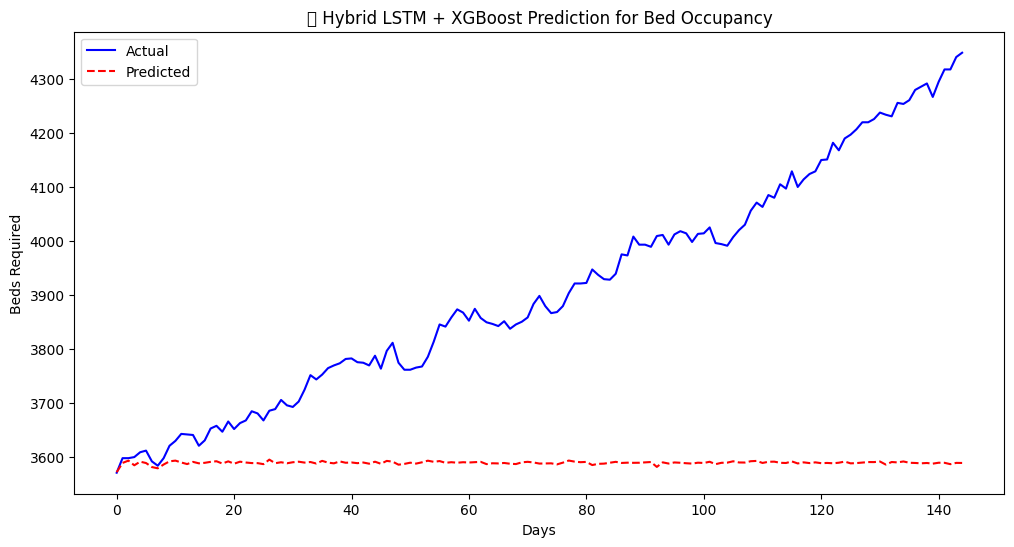

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from xgboost import XGBRegressor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
df = pd.read_csv("bed_data.csv")

# Feature Engineering: Add lag & moving average features
df["Beds_Occupied_Lag1"] = df["Total_Beds_Occupied_Today"].shift(1)
df["Beds_Occupied_Lag2"] = df["Total_Beds_Occupied_Today"].shift(2)
df["Beds_Occupied_MA3"] = df["Total_Beds_Occupied_Today"].rolling(window=3).mean()
df["Beds_Occupied_MA7"] = df["Total_Beds_Occupied_Today"].rolling(window=7).mean()
df["Beds_Occupied_Trend"] = df["Total_Beds_Occupied_Today"] - df["Total_Beds_Occupied_Today"].shift(7)

# Drop NaN values
df = df.dropna()

# Select Features & Target
features = [
    "Total_Admissions_Today", 
    "Total_Discharges_Today", 
    "Avg_LOS", 
    "Avg_Age_Admissions_Today", 
    "Total_Beds_Occupied_Today",
    "Beds_Occupied_Lag1",
    "Beds_Occupied_Lag2",
    "Beds_Occupied_MA3",
    "Beds_Occupied_MA7",
    "Beds_Occupied_Trend"
]
target = "Total_Beds_Required_Tomorrow"

X = df[features]
y = df[target]

# Train-Test Split
train_size = int(len(df) * 0.8)
X_train, X_test, y_train, y_test = X.iloc[:train_size], X.iloc[train_size:], y.iloc[:train_size], y.iloc[train_size:]

# Normalize Data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM (samples, time steps, features)
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Build LSTM Model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(1, X_train.shape[1])),
    LSTM(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.003), loss='mse')

# Train LSTM
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=16, validation_data=(X_test_lstm, y_test), callbacks=[early_stopping], verbose=1)

# Extract LSTM Predictions as Features
train_lstm_features = lstm_model.predict(X_train_lstm)
test_lstm_features = lstm_model.predict(X_test_lstm)

# Add LSTM Features to XGBoost Model
X_train_final = np.hstack((X_train_scaled, train_lstm_features))
X_test_final = np.hstack((X_test_scaled, test_lstm_features))

# Train Optimized XGBoost
xgb_model = XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.8,
    gamma=0.2,
    random_state=42
)
xgb_model.fit(X_train_final, y_train)

# Predictions
y_pred = xgb_model.predict(X_test_final)

# Evaluate Model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"🚀 R² Score: {r2:.4f}")  # Should be high
print(f"📉 RMSE: {rmse:.2f}")

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", color='blue')
plt.plot(y_pred, label="Predicted", linestyle="dashed", color='red')
plt.xlabel("Days")
plt.ylabel("Beds Required")
plt.title("🔥 Hybrid LSTM + XGBoost Prediction for Bed Occupancy")
plt.legend()
plt.show()


c:\Users\HARSHDIP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.1679 - val_loss: 0.0653
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0516 - val_loss: 0.1260
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0272 - val_loss: 0.0276
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0129 - val_loss: 0.0108
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0087 - val_loss: 0.0089
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0074 - val_loss: 8.1669e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0086 - val_loss: 0.0222
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0076 - val_loss: 0.0122
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0045 - val_loss: 9.9583e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0042 - val_loss: 5.3067e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0042 - val_loss: 0.0147
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 

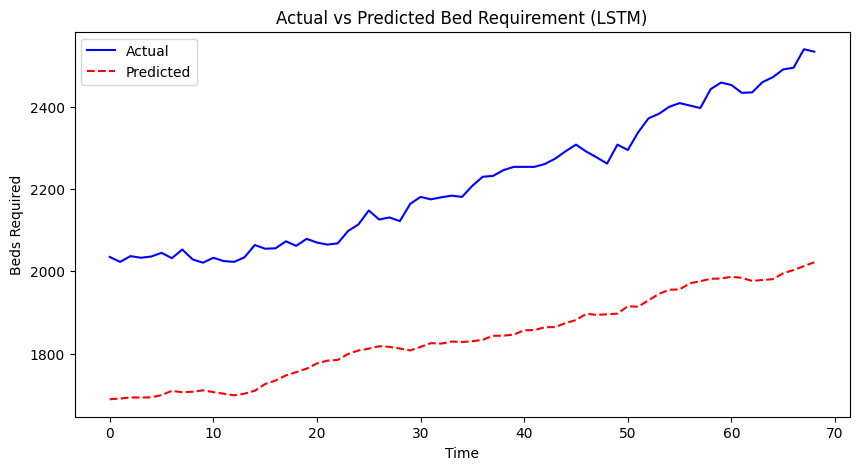

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from sklearn.metrics import mean_absolute_error, r2_score

# # Load dataset
# df = pd.read_csv("bed_data.csv")

# # Ensure Date column is formatted correctly


# # Selecting required columns
# features = [
#     "Total_Admissions_Today",
#     "Total_Discharges_Today",
#     "Avg_LOS",
#     "Avg_Age_Admissions_Today",
#     "Total_Beds_Occupied_Today"
# ]
# target = "Total_Beds_Required_Tomorrow"

# # Normalize data
# scaler = MinMaxScaler(feature_range=(0, 1))
# df_scaled = scaler.fit_transform(df[features + [target]])

# # Convert data to sequences
# def create_sequences(data, time_steps=10):
#     X, Y = [], []
#     for i in range(len(data) - time_steps):
#         X.append(data[i : i + time_steps, :-1])  # All features except target
#         Y.append(data[i + time_steps, -1])  # Target column
#     return np.array(X), np.array(Y)

# # Set time steps
# time_steps = 20  # Using a longer sequence for better learning
# X, Y = create_sequences(df_scaled, time_steps)

# # Train-Test Split (80% train, 20% test)
# train_size = int(len(X) * 0.8)
# X_train, X_test = X[:train_size], X[train_size:]
# Y_train, Y_test = Y[:train_size], Y[train_size:]

# # Build LSTM Model
# model = Sequential([
#     LSTM(128, activation='relu', return_sequences=True, input_shape=(time_steps, X.shape[2])),
#     Dropout(0.3),
#     LSTM(64, activation='relu', return_sequences=False),
#     Dropout(0.3),
#     Dense(32, activation='relu'),
#     Dense(1)  # Output layer
# ])

# # Compile Model
# model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# # Train Model
# history = model.fit(X_train, Y_train, epochs=100, batch_size=16, validation_data=(X_test, Y_test), verbose=1)

# # Make Predictions
# Y_pred = model.predict(X_test)

# # Inverse transform predictions
# Y_pred = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], Y_pred.reshape(-1, 1)), axis=1))[:, -1]
# Y_test = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], Y_test.reshape(-1, 1)), axis=1))[:, -1]

# # Evaluate Model
# mae = mean_absolute_error(Y_test, Y_pred)
# r2 = r2_score(Y_test, Y_pred)
# print(f"Mean Absolute Error: {mae:.2f}")
# print(f"R² Score: {r2:.4f}")

# # Predict Next Day
# last_sequence = X[-1].reshape(1, time_steps, X.shape[2])
# next_day_forecast = model.predict(last_sequence)
# next_day_forecast = scaler.inverse_transform(np.concatenate((X[-1, -1, :], next_day_forecast.flatten()), axis=0).reshape(1, -1))[:, -1]
# print(f"Predicted beds required tomorrow: {next_day_forecast[0]:.2f}")

# # Plot Actual vs Predicted
# plt.figure(figsize=(10, 5))
# plt.plot(Y_test, label='Actual', color='blue')
# plt.plot(Y_pred, label='Predicted', color='red', linestyle='dashed')
# plt.xlabel('Time')
# plt.ylabel('Beds Required')
# plt.title('Actual vs Predicted Bed Requirement (LSTM)')
# plt.legend()
# plt.show()
